# Heavy quarks probing Glasma flux tubes

## Default simulation parameters for the Glasma and the Wong solvers.

In [1]:
import numpy as np

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

# General parameters
# su_group = 'su2'        # Gauge group
su_group = 'su3' 

# Simulation box parameters
L = 2      # Length of simulation box [fm]
N = 512     # Number of lattice sites
tau_sim = 0.2     # Simulation time [fm/c]
DTS = 8     # Time step

# MV model parameters
Qs = 2              # Saturation momentum [GeV]	
ns = 1     # Number of color sheets
g = 2.0           # Running coupling constant	
mu = 0.5           # MV model parameter	
ir = 0.2        # Infrared regulator [GeV]
uv = 10.0           # Ultraviolet regulator [GeV]

# Heavy quark related parameters, chosen here for a charm quark
quark = 'charm'     # Quark type
mass = 1.27      # Heavy quark mass [GeV]
tau_form = 1/(2*mass)*hbarc     # Formation time [fm/c]
pT = 0.5    # Initial transverse momentum [GeV]
ntp = 15   # Number of test particles

seed = 314

representation = 'fundamental'      
boundary = 'periodic'
initialization = 'toy'    

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,       
    'PT': pT, 
    }

## Set environment variables and import all relevant modules.

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
wong.WONG_TO_HOST = True
from curraun.wong import init_charge
# Energy density
from curraun.energy import Energy

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

Using CUDA
Using SU(3)
Using double precision
Using double precision


## Glasma energy density

In [3]:
from tqdm import tqdm
import pickle

# Derived parameters
a = L / N
E0 = N / L * hbarc
DT = 1.0 / DTS
formt = int(p['TFORM'] / a * DTS)
maxt = int(tau_sim / a * DTS)

# Initialize Glasma fields
mv.set_seed(seed)
s = core.Simulation(N, DT, g)
va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
initial.init(s, va, vb)

# Initialize energy computation
energy = Energy(s)
ed = []

masses = [1.27, 4.18]
form_t = []
for mass in masses:
    form_t.append(1/(2*mass)*hbarc/a*DTS)
taus = [1, int(form_t[0]), int(form_t[1]), maxt]

with tqdm(total=maxt) as pbar:
    for t in range(1, maxt+1):
        # Evolve Glasma fields
        core.evolve_leapfrog(s)

        if t in taus:
            # Energy density calculation
            energy.compute()
            # units [Gev / fm^3]
            units = E0 ** 4 / hbarc ** 3
            el, bl, et, bt = energy.EL.reshape(N, N), energy.BL.reshape(N, N), energy.ET.reshape(N, N), energy.BT.reshape(N, N)
            e = (el+et+bl+bt)/t/g**2
            ed.append(e*units)

        pbar.update(1)

output = {}
output['ed'], output['N'], output['L'] = ed, N, L
max_index = np.unravel_index(ed[0].argmax(), ed[0].shape)
output['max_index'] = max_index
filename = 'energy_density_' + str(su_group) + '.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

100%|██████████| 409/409 [01:23<00:00,  4.88it/s]


## Simulation routine for evolving the Glasma & solving Wong's equations
Stores positions and momenta for the particles and the energy density of a single Glasma event

In [4]:
from tqdm import tqdm
import pickle

data_ed = pickle.load(open('energy_density_' + str(su_group) + '.pickle', 'rb'))
max_index = data_ed['max_index']

# Simulation routine
def simulate(p): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    mv.set_seed(seed)
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    pT = p['PT'] / E0
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    mass = p['MASS'] / E0 
    m = mass * np.ones(ntp)
    angles = 2*np.pi*np.random.rand(ntp)

    for i in range(ntp):
        # Positions
        # Initialize all quarks in the middle
        x0 = [max_index[0], max_index[1], 0]
        # Momenta
        p0 = [0.0, pT * np.cos(angles[i]), pT * np.sin(angles[i]), 0.0, 0.0]
        # Charges
        q0 = init_charge(representation)

        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, m)
    xTs = np.zeros((maxt-formt, ntp, 2))
    pTs = np.zeros((maxt-formt, ntp, 2))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                wong_solver.evolve()
                x = wong_solver.x0.copy()
                p = wong_solver.p.copy()
                for ip in range(ntp):
                    xTs[t-formt, ip, :] = [x[ip, 0], x[ip, 1]]
                    pTs[t-formt, ip, :] = [p[ip, 1], p[ip, 2]]

            pbar.update(1)

    return xTs, pTs

## Run for various transverse momenta and quarks

In [5]:
# quarks = ['massive', 'charm', 'beauty']
# quark_masses = [200, 1.27, 4.18]
# pTs = [0.5, 5.0, 10.0]
# pTs = [0, 2, 5]

quarks = ['jets']
# quark_masses = [1]
quark_masses = [0.01]
pTs = [10, 50, 100]

xT_sim, pT_sim, tau = {}, {}, {}
for iq in range(len(quarks)):
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    # heavy quarks
    # p['TFORM'] = 1/(2*p['MASS'])*hbarc 
    # jets
    p['TFORM'] = 0
    print(p['QUARK'].capitalize() + " quark")

    for pT in pTs:
        print('Transverse momentum', pT, 'GeV')
        p['PT'] = pT
        tag = quarks[iq] + '_pT_' + str(pT)
        
        formt, maxt = int(p['TFORM'] / L * N * DTS), int(tau_sim / L * N * DTS)
        tau_s = np.linspace(p['TFORM'], tau_sim, maxt-formt)

        xT_sim[tag], pT_sim[tag] = simulate(p)
        tau[tag] = tau_s

output = {}
output['quarks'], output['pTs'], output['masses'] = quarks, pTs, quark_masses
output['xT'], output['pT'], output['tau'] = xT_sim, pT_sim, tau
filename = 'flux_tubes_' + str(su_group) + '_jets.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(output, handle)

Jets quark
Transverse momentum 10 GeV


100%|██████████| 409/409 [02:08<00:00,  3.19it/s]


Transverse momentum 50 GeV


100%|██████████| 409/409 [01:49<00:00,  3.73it/s]


Transverse momentum 100 GeV


100%|██████████| 409/409 [01:49<00:00,  3.74it/s]


## Heavy quarks

### Read data from file using Julia

In [1]:
using Pickle

data_particles = Pickle.npyload("results/flux_tubes_su2_hqs.pickle")
quarks, pTs = data_particles["quarks"], data_particles["pTs"]
xT, p, tau = data_particles["xT"], data_particles["pT"], data_particles["tau"]

data_fields = Pickle.npyload("results/energy_density_su2.pickle")
ed, N, L = data_fields["ed"], data_fields["N"], data_fields["L"]
max_index = data_fields["max_index"]

function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

string_as_varname (generic function with 1 method)

### Plot using Makie from Julia

#### Final version

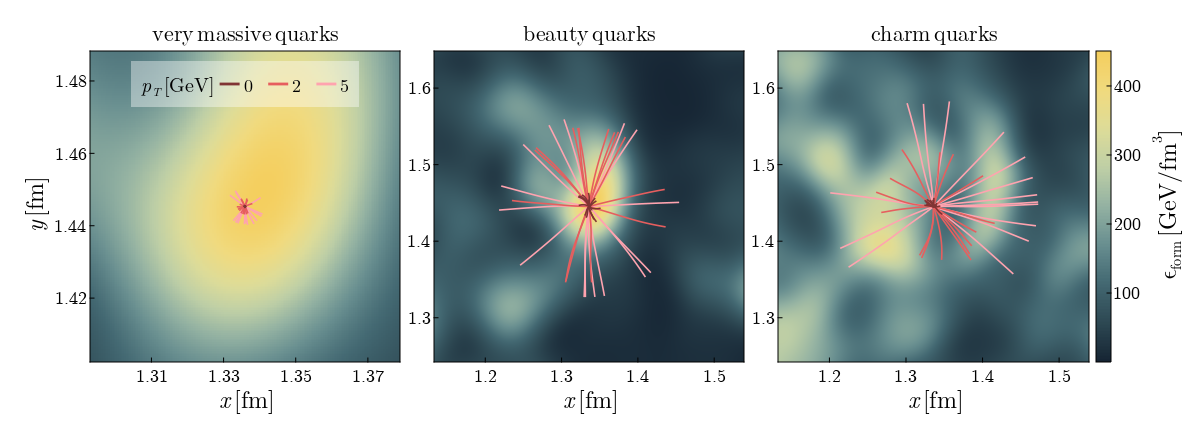

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000f07c080, 6000.0, 2150.0)


In [3]:
using CairoMakie
using Interpolations
using ColorSchemes

starrynight = cgrad(:starrynight, 11, categorical = true)
colors = ["#803434", "#e65e5e", "#FFA3AF"]


fig = Figure(resolution = (1200, 430), font = "CMU Serif")
titles = [L"\mathrm{beauty\,quarks}", L"\mathrm{charm\,quarks}"]
axes_noy = [Axis(fig[1, i], aspect=1, xlabel=L"x\,\mathrm{[fm]}", title=titles[i-1], titlesize = 22,
            xlabelsize = 24, ylabelsize= 24, xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5, xticklabelsize = 18, yticklabelsize = 18, xlabelpadding = -5) for i in 2:3]
axes = [Axis(fig[1, 1], aspect=1, xlabel=L"x\,\mathrm{[fm]}", ylabel=L"y\,\mathrm{[fm]}", title=L"\mathrm{very\,massive\,quarks}", titlesize = 22,
        xlabelsize = 24, ylabelsize= 24, xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5, xticklabelsize = 18, yticklabelsize = 18, xlabelpadding = -5),
        axes_noy[1], axes_noy[2]]

δs = [11, 52, 52]
step = 1/8
a = L/N
x, y = a*(1:N), a*(1:N)

for i in 1:3
    interp = interpolate(ed[i], BSpline(Quadratic(Reflect(OnCell()))))
    ed_interp = interp(1:step:N, 1:step:N)

    if i==1
        hmap = heatmap!(axes[i], x, y, ed_interp, colormap = (:starrynight, 1))
        cbar = Colorbar(fig, hmap, label = L"\epsilon_\mathrm{form}\,\mathrm{[GeV/fm^3]}", labelsize = 24, width = 15, flipaxis = true,
        ticksize=5, tickalign = 1, ticklabelsize = 18, height = Relative(1))
        fig[1, 4] = cbar
        colgap!(fig.layout, 7)
    else
        heatmap!(axes[i], x, y, ed_interp, colormap = (:starrynight, 1))
    end

    xlims!(axes[i], (max_index[1]-δs[i])*a, (max_index[1]+δs[i])*a)
    ylims!(axes[i], (max_index[2]-δs[i])*a, (max_index[2]+δs[i])*a)

    for ipT in (size(pTs)[1]):-1:1
        tag = quarks[i]*"_pT_"*string(pTs[ipT])
        ntp = size(xT[tag])[2]
        for tp in 1:ntp
                lines!(axes[i], xT[tag][:,tp,1]*a, xT[tag][:,tp,2]*a, 
                linewidth = 1.6, color = colors[ipT]
                )
        end
    end   
end

axes[1].xticks, axes[1].yticks = (1.31:0.02:1.37), (1.42:0.02:1.48)

for i in 1:3
    string_as_varname("line_"*string(i), LineElement(color = colors[i], linewidth=2.8))
end
axislegend(axes[1], [line_1, line_2, line_3], [L"0", L"2", L"5"], L"p_T\,\mathrm{[GeV]}", labelsize=18, titlesize=20,   
    position = :ct, bgcolor = (:white, 0.4), orientation = :horizontal, titleposition = :left, framecolor=(:grey80, 0))

display(fig)
save("plots/hqs_flux_tubes_background.png", fig, px_per_unit = 5.0) 

#### Another verion

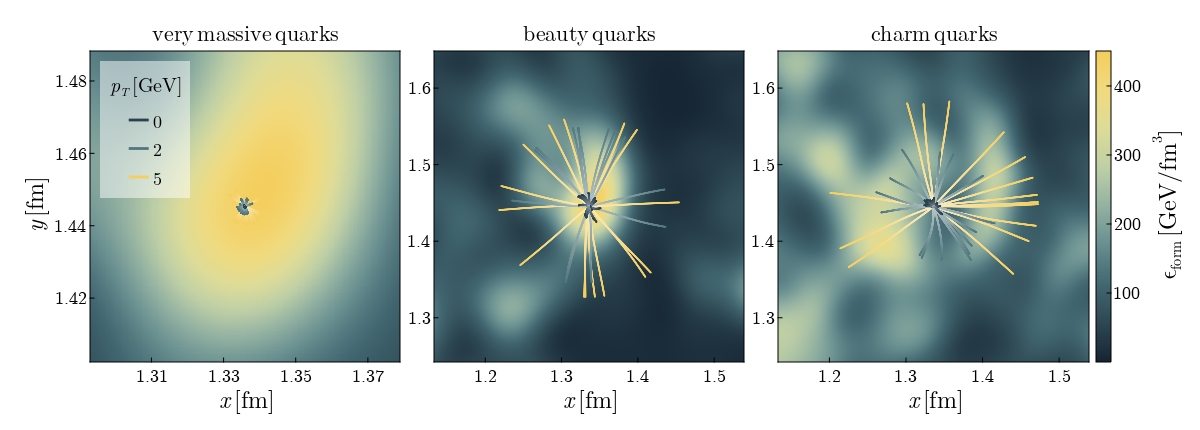

In [5]:
using CairoMakie
using Interpolations
using ColorSchemes

starrynight = cgrad(:starrynight, 11, categorical = true)
colors = [starrynight[2], starrynight[4], starrynight[11]]
light_colors = ["#a9b3b7", "#b9c8cb", "#faebbe"]

fig = Figure(resolution = (1200, 430), font = "CMU Serif")
titles = [L"\mathrm{beauty\,quarks}", L"\mathrm{charm\,quarks}"]
axes_noy = [Axis(fig[1, i], aspect=1, xlabel=L"x\,\mathrm{[fm]}", title=titles[i-1], titlesize = 22,
            xlabelsize = 24, ylabelsize= 24, xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5, xticklabelsize = 18, yticklabelsize = 18, xlabelpadding = -5) for i in 2:3]
axes = [Axis(fig[1, 1], aspect=1, xlabel=L"x\,\mathrm{[fm]}", ylabel=L"y\,\mathrm{[fm]}", title=L"\mathrm{very\,massive\,quarks}", titlesize = 22,
        xlabelsize = 24, ylabelsize= 24, xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5, xticklabelsize = 18, yticklabelsize = 18, xlabelpadding = -5),
        axes_noy[1], axes_noy[2]]

δs = [11, 52, 52]
step = 1/8
a = L/N
x, y = a*(1:N), a*(1:N)

for i in 1:3
    interp = interpolate(ed[i], BSpline(Quadratic(Reflect(OnCell()))))
    ed_interp = interp(1:step:N, 1:step:N)

    if i==1
        hmap = heatmap!(axes[i], x, y, ed_interp, colormap = (:starrynight, 1))
        cbar = Colorbar(fig, hmap, label = L"\epsilon_\mathrm{form}\,\mathrm{[GeV/fm^3]}", labelsize = 24, width = 15, flipaxis = true,
        ticksize=5, tickalign = 1, ticklabelsize = 18, height = Relative(1))
        fig[1, 4] = cbar
        colgap!(fig.layout, 7)
    else
        heatmap!(axes[i], x, y, ed_interp, colormap = (:starrynight, 1))
    end

    xlims!(axes[i], (max_index[1]-δs[i])*a, (max_index[1]+δs[i])*a)
    ylims!(axes[i], (max_index[2]-δs[i])*a, (max_index[2]+δs[i])*a)

    for ipT in (size(pTs)[1]):-1:1
        tag = quarks[i]*"_pT_"*string(pTs[ipT])
        ntp = size(xT[tag])[2]
        for tp in 1:ntp
                lines!(axes[i], xT[tag][:,tp,1]*a, xT[tag][:,tp,2]*a, 
                # linewidth = 1, color = tau[tag], colormap = cgrad([:white, colors[ipT]], alpha=0.8)
                linewidth = 1.6, color = tau[tag], colormap = cgrad([light_colors[ipT], colors[ipT]], alpha=1)
                )
        end
    end   
end

axes[1].xticks, axes[1].yticks = (1.31:0.02:1.37), (1.42:0.02:1.48)

for i in 1:3
    string_as_varname("line_"*string(i), LineElement(color = colors[i], linewidth=2.8))
end
axislegend(axes[1], [line_1, line_2, line_3], [L"0", L"2", L"5"], L"p_T\,\mathrm{[GeV]}", labelsize=18, titlesize=20, position = :lt, orientation = :vertical, bgcolor = (:white, 0.5), framecolor=(:grey80, 0))

display(fig)
# save("hqs_flux_tubes_background_v5.png", fig, px_per_unit = 5.0) 

## Jets

### Read data from file using Julia

In [7]:
using Pickle

data_particles = Pickle.npyload("results/flux_tubes_su2_jets.pickle")
quarks, pTs = data_particles["quarks"], data_particles["pTs"]
xT, p, tau = data_particles["xT"], data_particles["pT"], data_particles["tau"]

data_fields = Pickle.npyload("results/energy_density_su2.pickle")
ed, N, L = data_fields["ed"], data_fields["N"], data_fields["L"]
max_index = data_fields["max_index"]

function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

string_as_varname (generic function with 1 method)

### Plot using Makie from Julia

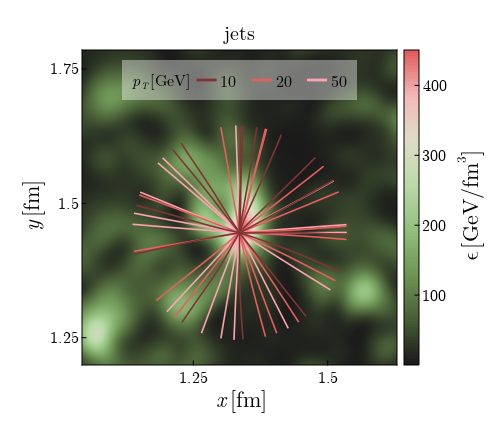

CairoScreen{Cairo.CairoSurfaceBase{UInt32}} with surface:
Cairo.CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000f660370, 2500.0, 2150.0)


In [9]:
using CairoMakie
using Interpolations
using ColorSchemes

colormap = cgrad(:watermelon, 11, categorical = true)
# colors = [colormap[2], colormap[4], colormap[11]]
colors = ["#803434", "#e65e5e", "#FFA3AF"]

fig = Figure(resolution = (500, 430), font = "CMU Serif")
axes = Axis(fig[1, 1], aspect=1, xlabel=L"x\,\mathrm{[fm]}", ylabel=L"y\,\mathrm{[fm]}", 
        title=L"\mathrm{jets}", 
        titlesize = 20,
        xlabelsize = 22, ylabelsize= 22, xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5, xticklabelsize = 16, yticklabelsize = 16, xlabelpadding = -5)

δs = 75
step = 1/8
a = L/N
x, y = a*(1:N), a*(1:N)
yshift = 12

interp = interpolate(ed[1], BSpline(Quadratic(Reflect(OnCell()))))
ed_interp = interp(1:step:N, 1:step:N)

hmap = heatmap!(axes, x, y, ed_interp, colormap = (:watermelon, 1))
# hmap = heatmap!(axes, x, y, ed_interp, colormap = (:starrynight, 1))
cbar = Colorbar(fig, hmap, label = L"\epsilon\,\mathrm{[GeV/fm^3]}", labelsize = 22, width = 15, flipaxis = true,
ticksize=5, tickalign = 1, ticklabelsize = 16, height = Relative(0.99))
fig[1, 2] = cbar
colgap!(fig.layout, 7)

xlims!(axes, (max_index[1]-δs)*a, (max_index[1]+δs)*a)
ylims!(axes, (max_index[2]-δs+yshift)*a, (max_index[2]+δs+yshift)*a)

for ipT in (size(pTs)[1]):-1:1
    tag = quarks[1]*"_pT_"*string(pTs[ipT])
    ntp = size(xT[tag])[2]
    for tp in 1:ntp
        lines!(axes, xT[tag][:,tp,1]*a, xT[tag][:,tp,2]*a, 
        # linewidth = 1, color = tau[tag], colormap = cgrad([:white, colors[ipT]], alpha=0.8)
        linewidth = 1.6, color = colors[ipT]
        )
    end
end   

for i in 1:3
    string_as_varname("line_"*string(i), LineElement(color = colors[i], linewidth=2.8))
end
axislegend(axes, [line_1, line_2, line_3], [L"10", L"20", L"50"], L"p_T\,\mathrm{[GeV]}", titlesize=16, labelsize=16,  position = :ct, 
    titleposition = :left, orientation = :horizontal, bgcolor = (:white, 0.4), framecolor=(:grey80, 0))

axes.xticks = ([1, 1.25, 1.5], ["1", "1.25", "1.5"])
axes.yticks = ([1.25, 1.5, 1.75], ["1.25", "1.5", "1.75"])

display(fig)
save("plots/jets_flux_tubes_background.png", fig, px_per_unit = 5.0) 